This notebook creates a Keras Sequence model that uses Xception as a trained base, freezes it, adds a head and trains it with a dataset of 31,000 299x299 images - half containing smoke and half no smoke. It then saves the model and tests it on some sample images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Make sure that we can connect to a TPU 
# Unfortunately this model cannot be trained on a GPU - it runs out of RAM with 27G of virtual memory very quickly
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.55.154.170:8470']


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Setup
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# Instantiate a base Xception model with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [6]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
# Freeze the base model
base_model.trainable = False

In [7]:
# Attach the head
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


In [8]:
# Compile the composite model
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 73,290,793
Trainable params: 52,429,313
Non-trainable params: 20,861,480
_________________________________________________________________


In [9]:
## LOAD THE DATA ##
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    #'train',
    '/content/drive/MyDrive/large',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    #'valid',
    '/content/drive/MyDrive/large',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=32,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Found 31310 files belonging to 2 classes.
Using 25048 files for training.
Found 31310 files belonging to 2 classes.
Using 6262 files for validation.


In [10]:
# Train the model on new data - the nosmoke and smoke image datasets
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=15,
    verbose=2,
)

Epoch 1/15
783/783 - 755s - loss: 0.2461 - binary_accuracy: 0.8948 - val_loss: 0.1842 - val_binary_accuracy: 0.9317
Epoch 2/15
783/783 - 1487s - loss: 0.1164 - binary_accuracy: 0.9538 - val_loss: 0.3625 - val_binary_accuracy: 0.8510
Epoch 3/15
783/783 - 1215s - loss: 0.0787 - binary_accuracy: 0.9693 - val_loss: 0.0267 - val_binary_accuracy: 0.9920
Epoch 4/15
783/783 - 1271s - loss: 0.0783 - binary_accuracy: 0.9710 - val_loss: 0.4239 - val_binary_accuracy: 0.8031
Epoch 5/15
783/783 - 1239s - loss: 0.0497 - binary_accuracy: 0.9806 - val_loss: 0.2181 - val_binary_accuracy: 0.9125
Epoch 6/15
783/783 - 1386s - loss: 0.0332 - binary_accuracy: 0.9885 - val_loss: 0.0143 - val_binary_accuracy: 0.9966
Epoch 7/15
783/783 - 1263s - loss: 0.0293 - binary_accuracy: 0.9893 - val_loss: 0.0037 - val_binary_accuracy: 0.9990
Epoch 8/15
783/783 - 1217s - loss: 0.0248 - binary_accuracy: 0.9903 - val_loss: 0.0080 - val_binary_accuracy: 0.9978
Epoch 9/15
783/783 - 1247s - loss: 0.0236 - binary_accuracy: 0.99

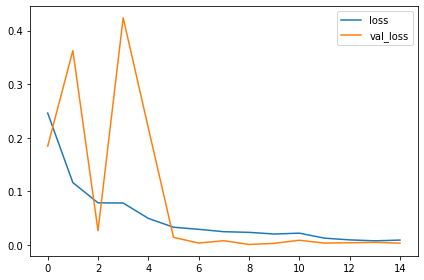

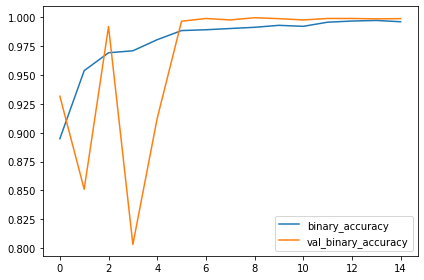

In [11]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [12]:
# Save our trained model
model.save('/content/drive/MyDrive/LargeXception')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/LargeXception/assets


In [13]:
reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/LargeXception')
# reloaded_model = tf.keras.models.load_model('TinyXception')

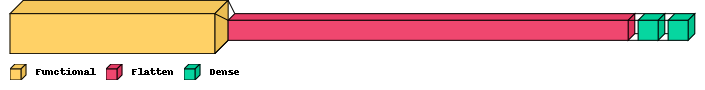

In [ ]:
# !pip install visualkeras
import visualkeras

model = reloaded_model

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png', legend=True).show() # write and show

visualkeras.layered_view(reloaded_model, legend=True)

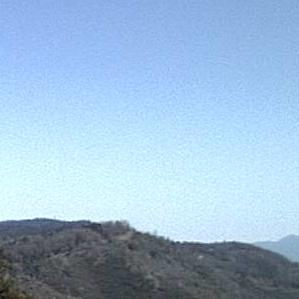

The image contains smoke.
0.58426166


In [29]:
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

# specify the image to be displayed and classified
image_path = '/content/drive/MyDrive/SmokeNoSmoke2.jpg'
# image_path = 'SmokeNoSmoke11.jpg'
image_size = (299,299)
from PIL import Image
import cv2 
from IPython.display import display

img = cv2.imread(image_path) # with the OpenCV function imread(), the order of colors is BGR (blue, green, red).
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB for Pillow
display(Image.fromarray(img))

image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = keras.preprocessing.image.img_to_array(image)
#print('first input array:',input_arr)
input_arr = np.array([input_arr])  # Convert single image to a batch.
#print('second input array:',input_arr)
x = preprocess_input(input_arr)
#print('x is:',input_arr)
predictions = reloaded_model.predict(x)

if predictions[0][0] <= 0.5:
    print("The image contains no smoke.")

if predictions[0][0] > 0.5:
    print("The image contains smoke.")

print(predictions[0][0])


Note: each Keras Application expects a specific kind of input preprocessing. 
For Xception, call tf.keras.applications.xception.preprocess_input on your inputs before passing them to the model.
xception.preprocess_input will scale input pixels between -1 and 1.

In [ ]:
# 2 different ways to prepare the image and pass it for prediction.....here is the second
img = keras.preprocessing.image.load_img(
    image_path, target_size=image_size   
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = reloaded_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent nosmoke and %.2f percent nosmoke."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent nosmoke and 0.00 percent nosmoke.


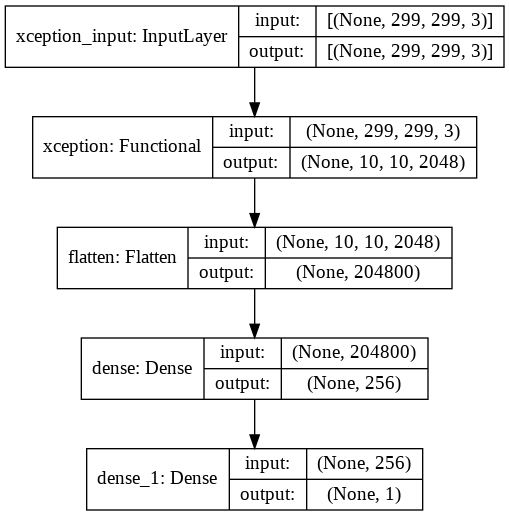

In [28]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(reloaded_model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)